In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/amazon_reviews.zip -d /content/dataset

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
import time
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 2.8.0


In [ ]:
!pip install nltk
!pip install wordcloud
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

### Load the Dataset

In [ ]:
reviews=pd.read_csv('/content/dataset/Reviews.csv')

In [ ]:
reviews.shape

(568454, 10)

In [ ]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Remove extra columns

In [ ]:
# Remove null values and unneeded features
reviews = reviews.dropna()
reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator',
                        'Score','Time'], 1)
reviews = reviews.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [ ]:
reviews

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...
...,...,...
568406,Will not do without,Great for sesame chicken..this is a good if no...
568407,disappointed,I'm disappointed with the flavor. The chocolat...
568408,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568409,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [ ]:
# Inspecting some of the reviews
for i in range(5):
    print("Review #",i+1)
    print(reviews.Summary[i])
    print(reviews.Text[i])
    print()

Review # 1
Good Quality Dog Food
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Review # 2
Not as Advertised
Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Review # 3
"Delight" says it all
This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces 

## Preparing Dataset

### 1. Expanding contractions

In [ ]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
contractions.get("an't")

### 2. Text Pre-processing

In [ ]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert to lowecase
    text=text.lower()
    
    # Replace contractions with their longer forms
    text=text.split()
    new_text=[]
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    
    text=" ".join(new_text)
    
    # Format words and remove unwanted characters
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:<>#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text



We will remove the stopwords from the texts because they do not provide much use for training our model. However, we will keep them for our summaries so that they sound more like natural phrases

In [ ]:
# Clean the summaries and texts
reviews['Summary']=reviews['Summary'].apply(lambda text: clean_text(text,False))

reviews['Text']=reviews['Text'].apply(lambda text: clean_text(text,True))

In [ ]:
# Inspecting some of the reviews
for i in range(5):
    print("Review #",i+1)
    print(reviews.Summary[i])
    print(reviews.Text[i])
    print()

Review # 1
good quality dog food
bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better

Review # 2
not as advertised
product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo

Review # 3
 delight  says it all
confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch

Review # 4
cough medicine
looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal

Review # 5
great taffy
great taffy great price wide assortment yummy taffy delivery quick taffy lover deal



### What are the things being talked about in the reviews?

Let's first try a simple word counter, and see the top 10 words?

In [ ]:
from collections import Counter
def flatten(list_of_list):
    flat_list=[]
    for l in list_of_list:
        flat_list.extend(l)
    return flat_list

In [ ]:
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def wordcloud_plot(counter_all):
    w=WordCloud().generate_from_frequencies(frequencies=dict(counter_all))
    plt.imshow(w)
    
def tokenize(text):
    tokens=[w for w in word_tokenize(text.lower())]
    return tokens

In [ ]:
counter_all=Counter(flatten(reviews["Text"].apply(tokenize).tolist()))
counter_all.most_common(10)

[('br', 619519),
 ('like', 251926),
 ('good', 197507),
 ('one', 173492),
 ('taste', 170099),
 ('great', 165073),
 ('coffee', 160798),
 ('would', 157769),
 ('product', 149531),
 ('flavor', 144816)]

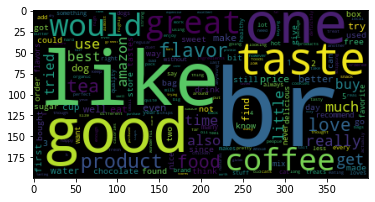

In [ ]:
wordcloud_plot(counter_all)

In [ ]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [ ]:
reviews.head()

,Summary,Text
0,good quality dog food,bought several vitality canned dog food produc...
1,not as advertised,product arrived labeled jumbo salted peanuts p...
2,delight says it all,confection around centuries light pillowy citr...
3,cough medicine,looking secret ingredient robitussin believe f...
4,great taffy,great taffy great price wide assortment yummy ...


In [ ]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

count_words(word_counts, reviews['Summary'])
count_words(word_counts, reviews['Text'])
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 117969


In [ ]:
# # Find the number of words that are missing from CN, and are used more than our threshold.
# missing_words = 0
# threshold = 20

# for word, count in word_counts.items():
#     if count > threshold:
#         if word not in embeddings_index:
#             missing_words += 1
            
# missing_ratio = round(missing_words/len(word_counts),4)*100
            
# print("Number of words missing from CN:", missing_words)
# print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

### Add The start and end Token in summary

In [ ]:
reviews['Summary']=reviews['Summary'].apply(lambda x: 'START ' + x + ' END')
reviews.head()

,Summary,Text
0,START good quality dog food END,bought several vitality canned dog food produc...
1,START not as advertised END,product arrived labeled jumbo salted peanuts p...
2,START delight says it all END,confection around centuries light pillowy citr...
3,START cough medicine END,looking secret ingredient robitussin believe f...
4,START great taffy END,great taffy great price wide assortment yummy ...


In [ ]:
## Length of max words in  Text
max([len(sentence.split()) for sentence in reviews['Text']])

2062

In [ ]:
# Another way
res = reviews['Text'].str.split().str.len().max()
res

2062

In [ ]:
lengths = reviews["Text"].str.len()
argmax = np.where(lengths == lengths.max())[0]
reviews.iloc[argmax]

,Summary,Text
290789,START an okay filtered municipal tap water wit...,fuzzy wuzzy summary br somewhat recommended re...
455358,START an okay filtered municipal tap water wit...,fuzzy wuzzy summary br somewhat recommended re...
496714,START an okay filtered municipal tap water wit...,fuzzy wuzzy summary br somewhat recommended re...


There are 3 Text of max length.

In [ ]:
### Let's divide the data into train and Test
x_train,x_valid,y_train,y_valid=train_test_split(
                             np.array(reviews["Text"]),
                             np.array(reviews["Summary"]),
                             test_size=0.1,
                             random_state=0,
                             shuffle=True)

In [ ]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((511569,), (56842,), (511569,), (56842,))

In [ ]:
def get_rare_words(text_col):
    
    # prepare a tokenizer on testing data
    text_tokenizer=Tokenizer()
    text_tokenizer.fit_on_texts(list(text_col))
    
    thresh=5
    
    cnt=0
    tot_cnt=0
    
    for key,value in text_tokenizer.word_counts.items():
        tot_cnt+=1
        if value< thresh:  # words which occour less then thresh times
            cnt+=1
            
    print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)
    
    return cnt, tot_cnt

## Config

In [ ]:
# Setup some configuration parameters 

config = {'min_text_len':40,
          'max_text_len':60,
          'max_summary_len':30,
          'latent_dim' : 300,
          'embedding_dim' : 200}

## TOkenize the Train Dataset

In [ ]:
x_train_cnt, x_train_tot_cnt = get_rare_words(text_col=x_train)

% of rare words in vocabulary: 62.23815190495079


In [ ]:
# txt_tokenizer=Tokenizer()
# txt_tokenizer.fit_on_texts(list(x_train[:10]))

# txt_tokenizer.word_counts

In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words=x_train_tot_cnt - x_train_cnt) 
x_tokenizer.fit_on_texts(list(x_train))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_train) 
x_val_seq = x_tokenizer.texts_to_sequences(x_valid)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=config['max_text_len'], padding='post')
x_val = pad_sequences(x_val_seq, maxlen=config['max_text_len'], padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 39984


## Tokenize the validation dataset

In [ ]:
y_train_cnt, y_train_tot_cnt = get_rare_words(text_col=y_train)

% of rare words in vocabulary: 65.95439373615747


In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=y_train_tot_cnt - y_train_cnt) 
# y_tokenizer = Tokenizer(num_words=y_train_tot_cnt) 
y_tokenizer.fit_on_texts(list(y_train))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_train) 
y_val_seq = y_tokenizer.texts_to_sequences(y_valid) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=config['max_summary_len'], padding='post')
y_val = pad_sequences(y_val_seq, maxlen=config['max_summary_len'], padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 10915


# Initialize the Encoder and Decoder architecture

In [ ]:
latent_dim = 300
embedding_dim = 200
max_text_len = 60
max_summary_len = 15

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 200)      7996800     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 300),    601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

## Compile and Train the Model

In [ ]:
platform='collab'
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

if platform == 'collab':
    model_name="/content/drive/MyDrive/model_15_epoch.h5"
elif platform == 'kaggle':
    model_name="./model_15_epoch.h5"
else:
    model_name="./model_15_epoch{epoch:03d}.h5"
    
save_model=tf.keras.callbacks.ModelCheckpoint(filepath=model_name,
                                              save_weights_only=True,
                                             save_best_only=True,
                                             verbose=1)
es=EarlyStopping(monitor='val_loss',
                mode='min',
                verbose=1,
                patience=10)

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=15,
    callbacks=[es, save_model],
    batch_size=256,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
    )

Epoch 1/15
1999/1999 [==============================] - ETA: 0s - loss: 0.9673 - accuracy: 0.8641
Epoch 1: val_loss improved from inf to 0.81776, saving model to /content/drive/MyDrive/model_15_epoch.h5
1999/1999 [==============================] - 1920s 955ms/step - loss: 0.9673 - accuracy: 0.8641 - val_loss: 0.8178 - val_accuracy: 0.8732
Epoch 2/15
1999/1999 [==============================] - ETA: 0s - loss: 0.7832 - accuracy: 0.8760
Epoch 2: val_loss improved from 0.81776 to 0.75773, saving model to /content/drive/MyDrive/model_15_epoch.h5
1999/1999 [==============================] - 1906s 954ms/step - loss: 0.7832 - accuracy: 0.8760 - val_loss: 0.7577 - val_accuracy: 0.8781
Epoch 3/15
1999/1999 [==============================] - ETA: 0s - loss: 0.7356 - accuracy: 0.8794
Epoch 3: val_loss improved from 0.75773 to 0.71613, saving model to /content/drive/MyDrive/model_15_epoch.h5
1999/1999 [==============================] - 1894s 947ms/step - loss: 0.7356 - accuracy: 0.8794 - val_loss:

# Plot the train and validation loss

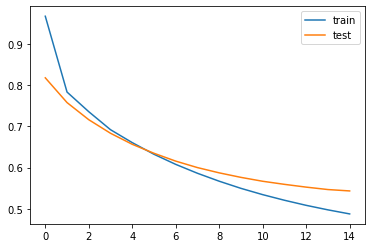

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

## Load the saved model

In [ ]:
model.load_weights('/content/drive/MyDrive/model_15_epoch.h5')

# Reverse encode the index to their tokens

In [ ]:
reverse_source_word_index = x_tokenizer.index_word
reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index

# Create the Decoder Inference architecture

In [ ]:
# #Inference Model

# Encode the input sequence to get the feature vector
encoder_model=Model(inputs=encoder_inputs,outputs=[encoder_outputs,state_h,state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h=Input(shape=(latent_dim,))
decoder_state_input_c=Input(shape=(latent_dim,))
decoder_hidden_state_input=Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2=dec_emb_layer(decoder_inputs)

#  To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2,state_h2,state_c2)=decoder_lstm(dec_emb2,
                                                  initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'end':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'end' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if (i != 0) and (i != target_word_index['start']) and (i != target_word_index['end']):
            newString = newString + reverse_target_word_index[i] + ' '

    return newString

# Prediction Summary

In [ ]:
actual = []
predicted = []
for i in range(0, 50):
    print ('Review:', seq2text(x_tr[i]))
    
    actual.append(seq2summary(y_tr[i]))
    print ('Original summary:', actual[-1])
    
    predicted.append(decode_sequence(x_tr[i].reshape(1, config['max_text_len'])))
    print ('Predicted summary:', predicted[-1])
    print()
    
prediction_df = pd.DataFrame({'Actual':actual, 'Predicted':predicted})
prediction_df.head(10)

Review: recently celebrated 40th birthday compadres treated 3 days gourmet home cooking opened jar truffle salt first night three us forever hooked put everything greek fries swiss raclette fondue american steaks wrong flavor distinctive way powering used moderation perfect compliment meal even put ice cream ask truffle lovers salt might well powdered heroin first timers delightful treat go disappointed 
Original summary: crack for foodies 
Predicted summary:  the ultimate snack

Review: good toffee flavor really suitable baking unless another sweetener accompanies like raw honey real maple syrup good yogurt probably would good coffee 
Original summary: yummy 
Predicted summary:  good stuff

Review: first experience black mustard seeds idea supposed taste know like one new favorite dishes cauliflower potatoes mustard seeds along indian spices make especially good 
Original summary: first time with this product 
Predicted summary:  great flavor

Review: sugar still floaters definitely c

,Actual,Predicted
0,crack for foodies,the ultimate snack
1,yummy,good stuff
2,first time with this product,great flavor
3,tastes good but there is bugs in mine,not as good as the original
4,delicious,good product
5,full bodied brew,good strong tea
6,ugh,ehhh
7,look candy bar,my favorite candy bar
8,not much flavor,great taste
9,instant yeast,great product
